In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import json
from IPython.display import HTML

In [2]:
def load_states(path):
    with open(path, "r") as f:
        states = json.load(f)

    # Optional: convert back to NumPy
    for s in states:
        s["x"] = np.array(s["x"])
        s["v"] = np.array(s["v"])
        s["a"] = np.array(s["a"])
        s["m"] = np.array(s["m"])
    return states

In [3]:
"""
def total_energy(x, v, m, G=6.67430e-11):
    KE = 0.5 * np.sum(m[:, None] * np.sum(v**2, axis=1))
    PE = 0.0
    N = len(m)
    for i in range(N):
        for j in range(i+1, N):
            r = np.linalg.norm(x[i] - x[j])
            if r == 0:
                continue
            else:
                PE -= G * m[i] * m[j] / r
    return KE + PE
"""
def total_energy(x, v, m, G=6.67430e-11):
    x = np.asarray(x)
    v = np.asarray(v)
    m = np.asarray(m)

    if x.ndim == 2:
        # single frame
        KE = 0.5 * np.sum(m * np.sum(v**2, axis=1))

        PE = 0.0
        N = len(m)
        for i in range(N):
            for j in range(i+1, N):
                r = np.linalg.norm(x[i] - x[j])
                if r > 0:
                    PE -= G * m[i] * m[j] / r

        return KE + PE

    elif x.ndim == 3:
        # multiple frames
        KE = 0.5 * np.sum(m[None, :] * np.sum(v**2, axis=2), axis=1)

        PE = np.zeros(x.shape[0])
        N = len(m)
        for i in range(N):
            for j in range(i+1, N):
                r = np.linalg.norm(x[:, i, :] - x[:, j, :], axis=1)
                mask = r > 0
                PE[mask] -= G * m[i] * m[j] / r[mask]

        return KE + PE

    else:
        raise ValueError("x and v must have shape (N,2) or (T,N,2)")

"""
def total_angular_momentum(x, v, m):
    L = np.zeros(3)
    for i in range(len(m)):
        r3 = np.array([x[i,0], x[i,1], 0])
        v3 = np.array([v[i,0], v[i,1], 0])
        L += m[i] * np.cross(r3, v3)
    return np.linalg.norm(L)
"""

def total_angular_momentum(x, v, m):
    # barycentric adjustment
    x = np.asarray(x)
    v = np.asarray(v)
    m = np.asarray(m)

    M = np.sum(m)

    if x.ndim == 2:
        # single frame
        r_cm = np.sum(m[:, None] * x, axis=0) / M
        v_cm = np.sum(m[:, None] * v, axis=0) / M

        L = np.zeros(3)
        for i in range(len(m)):
            r3 = np.array([x[i,0] - r_cm[0], x[i,1] - r_cm[1], 0.0])
            v3 = np.array([v[i,0] - v_cm[0], v[i,1] - v_cm[1], 0.0])
            L += m[i] * np.cross(r3, v3)

        return np.linalg.norm(L)

    elif x.ndim == 3:
        # multiple frames
        r_cm = np.sum(m[None, :, None] * x, axis=1) / M
        v_cm = np.sum(m[None, :, None] * v, axis=1) / M

        L = np.zeros((x.shape[0], 3))
        for i in range(len(m)):
            r3 = np.zeros((x.shape[0], 3))
            v3 = np.zeros((x.shape[0], 3))

            r3[:, :2] = x[:, i, :] - r_cm
            v3[:, :2] = v[:, i, :] - v_cm

            L += m[i] * np.cross(r3, v3)

        return np.linalg.norm(L, axis=1)

    else:
        raise ValueError("x and v must have shape (N,2) or (T,N,2)")

"""
def total_linear_momentum(v, m): 
    P = np.sum(m[:, None] * v, axis=0) 
    return np.linalg.norm(P)
"""

def total_linear_momentum(v, m):
    v = np.asarray(v)
    m = np.asarray(m)

    if v.ndim == 2:
        # single frame: (N, D)
        P = np.sum(m[:, None] * v, axis=0)
        return np.linalg.norm(P)

    elif v.ndim == 3:
        # multiple frames: (T, N, D)
        P = np.sum(m[None, :, None] * v, axis=1)
        return np.linalg.norm(P, axis=1)

    else:
        raise ValueError("v must have shape (N,D) or (T,N,D)")

"""
def center_of_mass(x, m):
    return np.linalg.norm(np.sum(m[:,None] * x, axis=0) / np.sum(m))
"""

def center_of_mass(x, m):
    x = np.asarray(x)
    m = np.asarray(m)

    if x.ndim == 2:
        r_cm = np.sum(m[:, None] * x, axis=0) / np.sum(m)
        return np.linalg.norm(r_cm)

    elif x.ndim == 3:
        r_cm = np.sum(m[None, :, None] * x, axis=1) / np.sum(m)
        return np.linalg.norm(r_cm, axis=1)

    else:
        raise ValueError("x must have shape (N,2) or (T,N,2)")



In [4]:
def plot_energy_error(errors, t):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Error")
    ax.set_title("Energy Error over time")
    ax.plot(t, errors)
    plt.show()

def plot_total_angular_momentum(dL, t):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Angular Momentum Drift [m/s]")
    ax.set_title("Total Angular Momentum Drift over time")
    ax.plot(t, dL)
    plt.show()

def plot_total_linear_momentum(dM, t):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Linear Momentum Drift [m/s]")
    ax.set_title("Total Linear Momentum Drift over time")
    ax.plot(t, dM)
    plt.show()

def plot_center_of_mass(com, t): 
    plt.figure(figsize=(12,6))
    plt.plot(t, com)
    plt.xlabel("Time [s]")
    plt.ylabel("|R_m| [m]")
    plt.title("Center of Mass Magnitude Drift")
    plt.show()

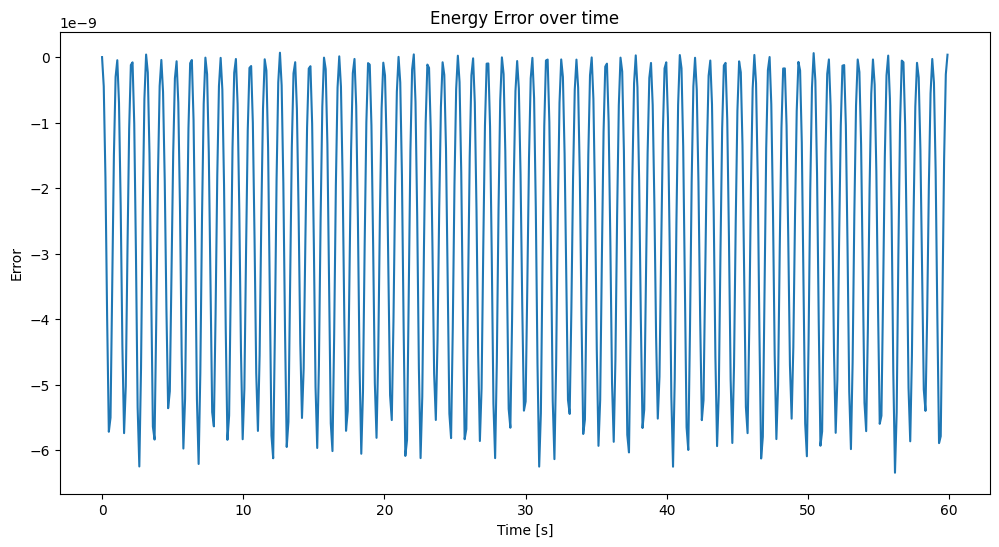

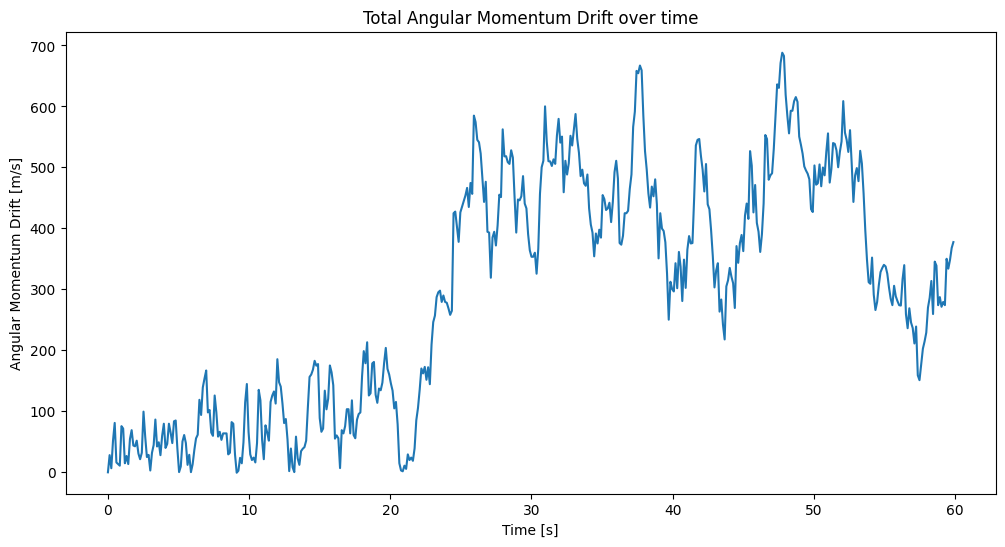

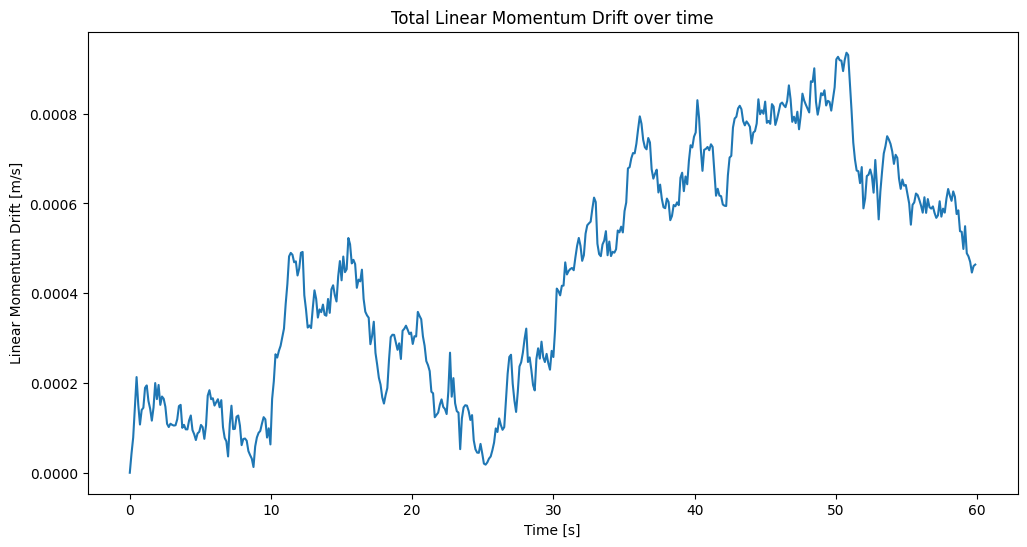

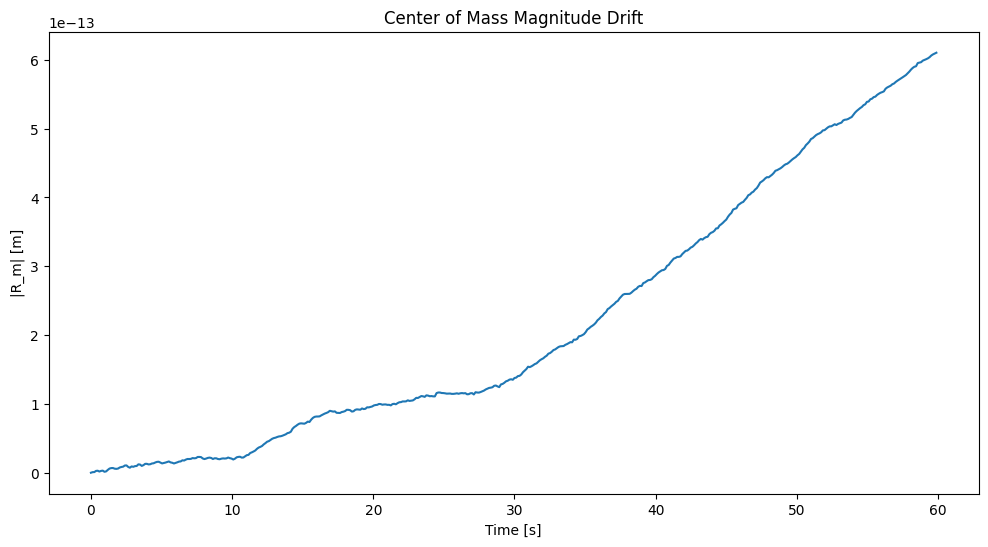

In [6]:
states = load_states("states_3body.json")
t = [s['t'] for s in states]

E0 = total_energy(states[0]['x'], states[0]['v'], states[0]['m'])
errors = [(total_energy(s['x'], s['v'], s['m']) - E0) / (abs(E0) if abs(E0) != 0 else 1) for s in states]
plot_energy_error(errors, t)

L0 = total_angular_momentum(states[0]['x'], states[0]['v'], states[0]['m'])
dL = [(total_angular_momentum(s['x'], s['v'],states[0]['m']) - L0) / (abs(L0) if abs(L0) != 0 else 1) for s in states]
plot_total_angular_momentum(dL, t)

M0 = total_linear_momentum(states[0]['v'], states[0]['m'])
dM = [(total_linear_momentum(s['v'], s['m']) - M0) / (abs(M0) if abs(M0) != 0 else 1) for s in states]
plot_total_linear_momentum(dM, t)

#com = np.linalg.norm([center_of_mass(s["x"], s["m"]) for s in states], axis=1)
com = [center_of_mass(s["x"], s["m"]) for s in states]
plot_center_of_mass(com, t)
#COM = center_of_mass(x, m)

In [ ]:
def body_characteristics(state, G=6.67430e-11, centre_index=None):
    """
    Compute characteristic values per body for one state.
    Returns a list of dicts, one per body.
    """
    x = state['x']
    v = state['v']
    m = state['m']
    N = len(m)

    # Optional centering
    if centre_index is not None:
        x = x - x[centre_index]
        v = v - v[centre_index]

    chars = []

    for i in range(N):

        # absolute velocity
        speed = np.linalg.norm(v[i])
        # linear momentum
        p_mag =  np.linalg.norm(m[i] * v[i])

        # Angular momentum 
        #L = m[i] * (x[i][0]*v[i][1] - x[i][1]*v[i][0]) #(z-component)
        r3 = np.array([x[i,0], x[i,1], 0])
        v3 = np.array([v[i,0], v[i,1], 0])
        L = m[i] * np.cross(r3, v3)
        L = np.linalg.norm(L)

        kinetic = 0.5 * m[i] * speed**2

        # Potential energy
        potential = 0.0
        for j in range(N):
            if i == j:
                continue
            r = np.linalg.norm(x[j] - x[i])
            potential -= 0.5 * G * m[i] * m[j] / r

        #potential = np.abs(potential)

        chars.append({
            "speed": speed,
            "momentum": p_mag,
            "angular_momentum": L,
            "kinetic_energy": kinetic,
            "potential_energy": potential,
            "total_energy": kinetic + potential
        })

    return chars

In [ ]:
def visual_analysis(states, body_names, colors=None, scale=1.0/1.496e11, inspect_body=None, centre_body=None, trail_length=50,
                         xlim=(-10,10), ylim=(-10,10), interval=50, save_path=None):
    """
    Visualize a precomputed trajectory of bodies with center on the Sun (0,0).

    states : list of dict
        Each dict must contain 'x' (Nx2 array) and 't' (float).
    body_names : list of str
        Names of bodies (length N).
    colors : list of str 
        Colors for bodies.
    scale : float
        Scaling factor for positions.
    centre_body : str
        name of the body from body_names list to centre the visualisation around
    trail_length : int
        How many past positions to show in trail.
    xlim, ylim : tuple
        Plot limits.
    interval : int
        Milliseconds between frames.
    save_path : str or None
        If given, saves animation to file (requires ffmpeg).
    """
    colors = colors
    n_bodies = len(body_names)

    if((inspect_body is not None) and (inspect_body in body_names)):
        inspect_index = np.where(body_names == inspect_body)[0][0]
    else:
        inspect_index = None
    
    if((centre_body is not None) and (centre_body in body_names)):
        centre_body_index = np.where(body_names == centre_body)[0][0]
    else:
        centre_body_index = None

    # TODO: states preproc: scale and offset calc
    
    # Figure setup
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_aspect("equal")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("x (scaled)")
    ax.set_ylabel("y (scaled)")
    ax.set_title("Sol System")
    
    #Scatter objects for bodies positions
    scatters = [ax.scatter([], [], color=colors[i], s=80, label=body_names[i]) for i in range(n_bodies)]

    # Time text
    time_text = ax.text(0.02, 0.98, "", transform=ax.transAxes, ha="left", va="top", fontsize=9, bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    # Body info text
    info_text = ax.text(0.02, 0.02, "", transform=ax.transAxes, ha="left", va="bottom", fontsize=9, bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    
    def init():    
        if(centre_body_index is not None):
            centre_body_offset = states[0]['x'][centre_body_index]
        else:
            centre_body_offset = 0
            
        positions = (states[0]['x'] - centre_body_offset) * scale
        i = 0
        for sc in scatters:
            sc.set_offsets([positions[i]])
            i += 1
            
        time_text.set_text(f"t = {states[0]['t']:.1f} s")

        state = states[0]
        chars = body_characteristics(state, centre_index=centre_body_index)
        if inspect_index:
            c = chars[inspect_index]
        else: 
            c = chars[centre_body_index]

        info_text.set_text(
            f"{inspect_body}\n"
            f"|v| = {c['speed']:.3e} m/s\n"
            f"|p| = {c['momentum']:.3e} kg·m/s\n"
            f"L = {c['angular_momentum']:.3e} kg·m²/s\n"
            f"T = {c['kinetic_energy']:.3e} J\n"
            f"U = {c['potential_energy']:.3e} J\n"
            f"E = {c['total_energy']:.3e} J"
        )

        return tuple(scatters) + (time_text, info_text)

    
    def update(frame):
        state = states[frame]
        
        if(centre_body_index is not None):
            centre_body_offset = state['x'][centre_body_index]
        else:
            centre_body_offset = 0
        
        positions = (state['x'] - centre_body_offset) * scale
        t = state['t']

        # Update bodies positions
        for i, name in enumerate(body_names):
            scatters[i].set_offsets([positions[i]])

        # Update time
        time_text.set_text(f"t = {t:.1f} s")

        # Update info 
        chars = body_characteristics(state, centre_index=centre_body_index)
        if inspect_index:
            c = chars[inspect_index]
        else: 
            c = chars[centre_body_index]

        info_text.set_text(
            f"{inspect_body}\n"
            f"|v| = {c['speed']:.3e} m/s\n"
            f"|p| = {c['momentum']:.3e} kg·m/s\n"
            f"L = {c['angular_momentum']:.3e} kg·m²/s\n"
            f"T = {c['kinetic_energy']:.3e} J\n"
            f"U = {c['potential_energy']:.3e} J\n"
            f"E = {c['total_energy']:.3e} J"
        )

        return tuple(scatters) + (time_text, info_text)

    
    anim = FuncAnimation(fig, update, frames=len(states), init_func=init, blit=False, interval=interval)

    plt.legend()

    if save_path is not None:
        anim.save(save_path, writer="pillow")

    return anim

In [ ]:
bodies = [
    np.array([
        "AntiMercury",
        "Mercury",
    ]),
    # Colors (reasonable defaults for visualization)
    np.array([
        "red",        # Sun
        "blue",          # Mercury
    ]),
]

anim = visual_analysis(
    states=states,
    body_names=bodies[0],
    colors=bodies[1],
    inspect_body="Mercury",
    interval=200,
    xlim=(-2.0, 2.0), 
    ylim=(-2.0, 2.0),
    save_path="2_body_analysis.gif")

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
def lin_p(m, v):
    return np.linalg.norm(m * v)

def ang_p(m, x, v):
    r3 = np.array([x[0], x[1], 0])
    v3 = np.array([v[0], v[1], 0])
    L = m * np.cross(r3, v3)
    return np.linalg.norm(L)

def total_energy(m, v, x, G=6.67430e-11):
    
    speed = np.linalg.norm(v[1])
    KE = 0.5 * m[1] * speed**2
    # Potential energy
    PE = 0.0
    for j in range(len(m)):
        if 1 == j:
            continue
        r = np.linalg.norm(x[j] - x[1])
        PE -= 0.5 * G * m[1] * m[j] / r
    return KE + PE

t = [s['t'] for s in states]

E0 = total_energy(states[0]['x'], states[0]['v'], states[0]['m'])
errors = [(total_energy(s['x'], s['v'], s['m']) - E0) / abs(E0)
          for s in states]
plot_energy_error(errors, t)

L0 = ang_p(states[0]['x'][1], states[0]['v'][1], states[0]['m'][1])
dL = [ang_p(s['x'][1], s['v'][1],states[0]['m'][1] - L0) for s in states]
plot_total_angular_momentum(dL, t)

M0 = lin_p(states[0]['v'][1], states[0]['m'][1])
dM = [lin_p(s['v'][1], s['m'][1] - M0) for s in states]
plot_total_linear_momentum(dM, t)

#com = np.linalg.norm([center_of_mass(s["x"], s["m"]) for s in states], axis=1)
com = [center_of_mass(s["x"], s["m"]) for s in states]
plot_center_of_mass(com, t)

In [ ]:
print(states[0]['v'][1][0])